## **1. Import Library**

In [4]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Agar grafik lebih cantik
plt.style.use('ggplot')

## **2. Load Data**

In [5]:
from google.colab import drive

# 1. Sambungkan ke Drive
drive.mount('/content/drive')

# 2. Path File
path_file = '/content/drive/MyDrive/ML/OnlineRetail.csv'

# 3. Coba baca dengan beberapa encoding
encodings = ["latin1", "ISO-8859-1", "cp1252"]

for enc in encodings:
    try:
        df = pd.read_csv(path_file, encoding=enc, engine='python')
        break
    except Exception as e:
        print("Gagal dengan encoding:", enc)

# 4. Tampilkan data jika berhasil
try:
    display(df.head())
except:
    print("Gagal membaca file, cek kembali.")


ModuleNotFoundError: No module named 'google.colab'

In [7]:
nama_file = 'OnlineRetail.csv' 

if os.path.exists(nama_file):
    try:
        # Mencoba load dengan UTF-8 (standar)
        df = pd.read_csv(nama_file, encoding='utf-8')
    except UnicodeDecodeError:
        # Jika gagal (error), otomatis ganti ke ISO-8859-1 (cocok untuk OnlineRetail)
        print("Format UTF-8 gagal, beralih ke ISO-8859-1...")
        df = pd.read_csv(nama_file, encoding='ISO-8859-1')

    print("Data berhasil dimuat!")
    display(df.head(11))
else:
    print("File tidak ditemukan!")

Format UTF-8 gagal, beralih ke ISO-8859-1...
Data berhasil dimuat!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


## **3. Data Cleaning**

In [8]:
# Hapus baris yang tidak ada CustomerID-nya
df_clean = df.dropna(subset=['CustomerID'])

# Hapus transaksi return (Quantity negatif) dan harga 0
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Cek berapa sisa data kita
print(f"Data awal: {len(df)} baris")
print(f"Data setelah dibersihkan: {len(df_clean)} baris")


Data awal: 541909 baris
Data setelah dibersihkan: 397884 baris


## **4. Membuat Data RFM (Recency, Frequency, Monetary)**

In [10]:
# Perbaikan: Tambahkan dayfirst=True agar tanggal '13-12-2010' terbaca benar
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], dayfirst=True)
# Hitung total belanja per transaksi
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
# Tentukan tanggal acuan (1 hari setelah transaksi terakhir di data)
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)

# Kelompokkan per CustomerID
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalPrice': 'sum'                                     # Monetary
})
# Ganti nama kolom biar jelas
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)
# Tampilkan data RFM
print("Format tanggal berhasil diperbaiki!")
rfm.head()

Format tanggal berhasil diperbaiki!


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


## **5. Scaling (Menyamakan Skala Data)**

In [11]:
# Log transformation untuk mengatasi data yang terlalu jomplang (skewed)
rfm_log = np.log1p(rfm)
# Standard Scaler (Mean = 0, Std Dev = 1)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
# Kembalikan ke bentuk DataFrame agar mudah dibaca
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("Data sudah dinormalisasi dan siap untuk K-Means.")
rfm_scaled.head()

Data sudah dinormalisasi dan siap untuk K-Means.


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.461993,-2.434387,3.706225
12347.0,-2.038734,1.177483,1.411843
12348.0,0.373104,-0.217054,0.716489
12349.0,-0.623086,0.453387,0.698739
12350.0,1.424558,-0.677192,-0.618962


## **6. Mencari Jumlah Cluster (Elbow Method)**

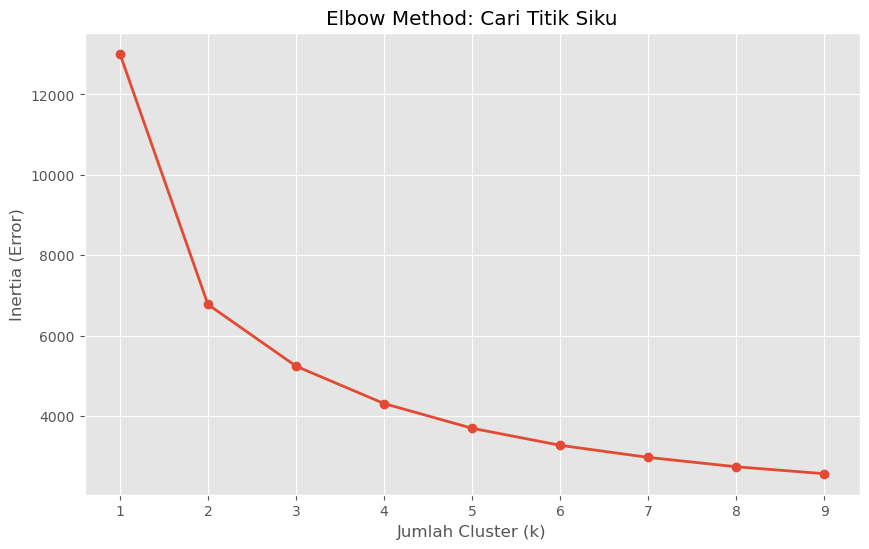

In [12]:
inertia = []
k_range = range(1, 10) # Coba dari 1 sampai 10 cluster

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Gambar Grafik
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.title('Elbow Method: Cari Titik Siku')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Error)')
plt.show()

## **7. Eksekusi Final & Analisis**

------- Profil Rata-Rata Tiap Cluster -------


,Recency,Frequency,Monetary
Cluster,,,
0,176.437541,15.337079,301.620397
1,15.119388,264.776531,6502.074010
2,64.854201,62.437940,1129.010143


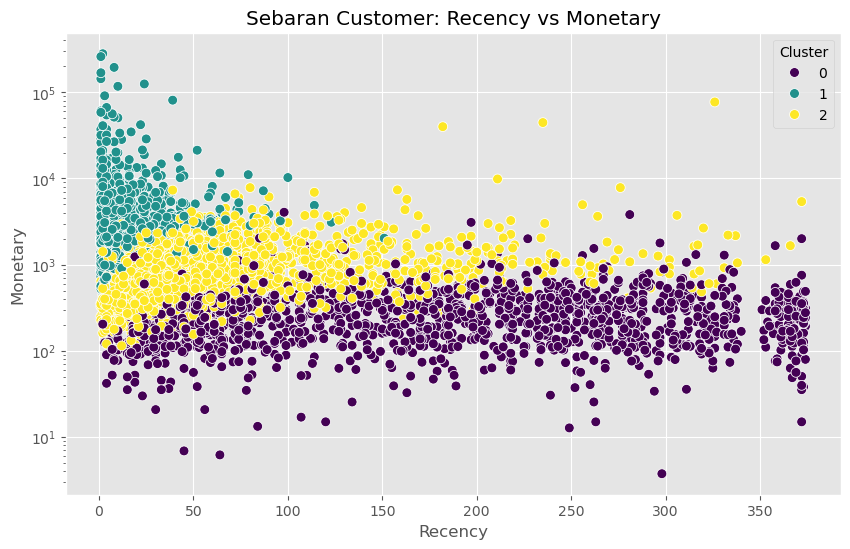

In [13]:
# Jalankan K-Means dengan 3 cluster
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_final.fit(rfm_scaled)

# Masukkan label hasil ke data asli (rfm)
rfm['Cluster'] = kmeans_final.labels_

# Lihat rata-rata karakteristik tiap cluster
print("------- Profil Rata-Rata Tiap Cluster -------")
display(rfm.groupby('Cluster').mean())

# Lihat sebaran datanya dengan grafik
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=50)
plt.yscale('log')
plt.title('Sebaran Customer: Recency vs Monetary')
plt.show()